# Oluwatosin Adewale

## DISEASE PREDICTION WITH NLP USING PATIENT SYMPTOM DESCRIPTIONS

### Loading the necessary packages and data

In [1]:
#!pip install torch torchtext transformers sentencepiece pandas tqdm datasets
#!pip install keras
#!pip install tensorflow
#!curl https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
# alternatively, do this with a progress bar
#!curl  --progress-bar -O https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install torch torchvision torchaudio
# Installing SPARQLWrapper to access the disease ontology
#!pip install SPARQLWrapper
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix"
#!pip install gensim
#!pip install keras
#!pip install tensorflow
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install transformers
#!pip install tf-keras
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz
#!pip install nlpaug
#!pip install transformers[torch]

  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchtext-0.18.0-cp312-cp312-win_amd64.whl.metadata (7.9 kB)
  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
  Using cached sentencepiece-0.2.0-cp312-cp312-win_amd64.whl.metadata (8.3 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.4.5-cp312-none-win_amd64.whl.metadata (3.9 kB)
  Using cached xxhash-3.5.0-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/203.0 MB 4.8 MB/s eta 0:00:43
   ---------------------------------------- 1.8/203.0 MB 5.3 MB/

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4') 
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Conv1D, MaxPooling1D, Flatten, Activation
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModelForTokenClassification, pipeline
from gensim.models import KeyedVectors
from SPARQLWrapper import SPARQLWrapper, JSON
from tqdm import tqdm
import time
import joblib
import ast


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tosin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tosin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tosin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tosin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Loading the Data

In [3]:
## Major Datasets
nls2d = pd.read_csv("Natural language Symptom2Disease prediction.csv")
textsympdata = pd.read_csv("full_textbased_symptom_dataset.csv")

In [4]:
textsympdata.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
textsympdata.sample(5)

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
4309,Drug Reaction,itching,skin_rash,stomach_pain,burning_micturition,spotting_ urination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,Malaria,chills,vomiting,high_fever,sweating,headache,nausea,diarrhoea,muscle_pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3480,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1889,Alcoholic hepatitis,vomiting,yellowish_skin,abdominal_pain,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2522,Hepatitis C,fatigue,yellowish_skin,nausea,loss_of_appetite,yellowing_of_eyes,family_history,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Choosing only the Disease and description columns
nls2d = nls2d[['Disease', 'text']]
nls2d.head()

,Disease,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [7]:
textsympdata.shape

(4920, 18)

In [8]:
nls2d.shape

(1200, 2)

#### Combining the disease symptom and text descriptions datasets

In [9]:
# Merging the datasets on the Disease column
combineddata = pd.merge(nls2d, textsympdata, on="Disease", how="outer")
print(combineddata)
combineddata.to_csv("Combined disease and symptom text data.csv", index=False)

                                       Disease  \
0      (vertigo) Paroymsal  Positional Vertigo   
1      (vertigo) Paroymsal  Positional Vertigo   
2      (vertigo) Paroymsal  Positional Vertigo   
3      (vertigo) Paroymsal  Positional Vertigo   
4      (vertigo) Paroymsal  Positional Vertigo   
...                                        ...   
93565                  urinary tract infection   
93566                  urinary tract infection   
93567                  urinary tract infection   
93568                  urinary tract infection   
93569                  urinary tract infection   

                                                    text  Symptom_1  \
0                                                    NaN   vomiting   
1                                                    NaN   vomiting   
2                                                    NaN   headache   
3                                                    NaN   vomiting   
4                                           

In [38]:
combineddata.head()

,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,(vertigo) Paroymsal Positional Vertigo,NaN,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(vertigo) Paroymsal Positional Vertigo,NaN,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(vertigo) Paroymsal Positional Vertigo,NaN,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(vertigo) Paroymsal Positional Vertigo,NaN,vomiting,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,(vertigo) Paroymsal Positional Vertigo,NaN,vomiting,headache,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
combineddata.sample(2)

,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
78138,Pneumonia,I'm drenched with sweat and struggling to brea...,chills,fatigue,cough,high_fever,breathlessness,malaise,phlegm,chest_pain,fast_heart_rate,rusty_sputum,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65223,Malaria,"I've had a high temperature, vomiting, chills,...",chills,vomiting,high_fever,sweating,headache,nausea,diarrhoea,muscle_pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88887,Typhoid,I am experiencing extreme belly pain and const...,chills,vomiting,fatigue,high_fever,headache,nausea,constipation,abdominal_pain,diarrhoea,toxic_look_(typhos),belly_pain,NaN,NaN,NaN,NaN,NaN,NaN
48721,Fungal infection,"My body has been itching terribly all over, an...",itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36311,Common Cold,I've had a terrible cough and cold for days. M...,continuous_sneezing,chills,fatigue,cough,high_fever,headache,swelled_lymph_nodes,malaise,phlegm,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,chest_pain,loss_of_smell,muscle_pain
85215,Psoriasis,My skin rash gets worse in the winter when the...,skin_rash,joint_pain,skin_peeling,small_dents_in_nails,inflammatory_nails,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35688,Common Cold,"I can't quit sneezing, and my nose is running....",continuous_sneezing,chills,fatigue,cough,high_fever,headache,malaise,phlegm,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,chest_pain,loss_of_smell,muscle_pain,NaN
44269,Fungal infection,I have an itchy skin and lots of red bumps on ...,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83046,Psoriasis,My nails have small dents on them. Even my joi...,skin_rash,joint_pain,skin_peeling,silver_like_dusting,inflammatory_nails,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90779,Typhoid,I have developed diarrhea. It is accompanied b...,chills,vomiting,fatigue,high_fever,headache,nausea,constipation,abdominal_pain,diarrhoea,toxic_look_(typhos),belly_pain,NaN,NaN,NaN,NaN,NaN,NaN


#### Understanding which diseases are responsible for the dataset explosion

In [43]:
# Count of rows for each disease in each dataset
nls2d_counts = nls2d['Disease'].value_counts()
textsympdata_counts = textsympdata['Disease'].value_counts()

# Merging the counts into one DataFrame
disease_merge_counts = pd.DataFrame({
    "nls2d_count": nls2d_counts,
    "textsympdata_count": textsympdata_counts
}).fillna(0)

# Adding an column for the expected rows
disease_merge_counts['expected_rows'] = disease_merge_counts['nls2d_count'] * disease_merge_counts['textsympdata_count']

# Summary
print(disease_merge_counts)
print(f"Expected total rows after merge: {disease_merge_counts['expected_rows'].sum()}")


                                         nls2d_count  textsympdata_count  \
Disease                                                                    
(vertigo) Paroymsal  Positional Vertigo          0.0               120.0   
AIDS                                             0.0               120.0   
Acne                                            50.0               120.0   
Alcoholic hepatitis                              0.0               120.0   
Allergy                                          0.0               120.0   
Arthritis                                       50.0               120.0   
Bronchial Asthma                                50.0               120.0   
Cervical spondylosis                            50.0               120.0   
Chicken pox                                     50.0               120.0   
Chronic cholestasis                              0.0               120.0   
Common Cold                                     50.0               120.0   
Dengue      

### Notes on Progress and Bottlenecks so far

**Notes**

* Had some difficulty getting the WedMD data and the Reddit one due to privacy issues with webscraping. Could not access MIMMIC data because it needs a full module of almost 15 courses to be completed and i only have about 5 or 6. Found a few other datasets on kaggle including 1 NLP symptom description and 1 chatbot conversation type dataset.

* Ran into a few problems parsing one of the dataets that could've been useful so may have to ask someone more experienced for help with that. It came in a funny format but even with the work i was able to do on it, I still couldn't load it.

* Ended up with 2 main datasets then the supplementary ones. I combined bothe text based and symptom description datasets into one. I tried merging it with the severity symptom data but ran into issues because the dictionary with the mapping for scores i had created was not exactly mounting well with teh combined dataset. All the severity mappings were showing up as NAN. The dict still exists though. Would reveist when establishing advanced modelling

* Major limitations were in finding/accessing the data then parsing it in a way that is readable or usable for the model, then the severity mapping issue.

Moving on to baseline modeling for now. I'll do logistic regression and decision trees, maybe incorporate a onevsrest classifier somewhere.

## Baseline modelling - TFIDF Logistic regression - For presentation


In [45]:
X = combineddata['text'].fillna('')  # Replacing all the NAN values empty strings
y = combineddata['Disease']

# Splitting data into training and test sets
X_train, X_test, y_train, b_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic regression model with One-vs-Rest classifier for multilabel classification
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(b_test, y_pred))
print("Classification Report:\n", classification_report(b_test, y_pred))


Accuracy: 0.9647857219194186


C:\Users\tosin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tosin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       0.02      1.00      0.04        13
                                   AIDS       0.00      0.00      0.00        24
                                   Acne       1.00      1.00      1.00      1151
                    Alcoholic hepatitis       0.00      0.00      0.00        33
                                Allergy       0.00      0.00      0.00        30
                              Arthritis       1.00      1.00      1.00      1212
                       Bronchial Asthma       1.00      1.00      1.00      1167
                   Cervical spondylosis       1.00      1.00      1.00      1209
                            Chicken pox       0.99      1.00      1.00      1186
                    Chronic cholestasis       0.00      0.00      0.00        18
                            Common Cold       1.00      1.00      1.00      1247
   

C:\Users\tosin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


** Notes:
This tells me I need to find a way to balance this dataset. Creating synthetic data for the diseaseswith the minority representations perhaps?. Some of them are not even being predicted at all, giving them a score of 0.00 for precision, recall, and f1.

From what i can see, those withe teh smaller number of samples have the lowest prediction accuracies compared to the more abundant diseases
Perhps I could try techniques like oversampling minority classes or undersampling majority classes to balance the dataset.

In [47]:
# Defining a function to process and predict from user input - For demo
def predict_disease(symptom_text, model, tfidf_vectorizer, top_n=5):
    
    # Converting the input text into a TF-IDF vector
    symptom_vector = tfidf_vectorizer.transform([symptom_text])

    # Predicting probabilities for each disease
    probabilities = model.predict_proba(symptom_vector)[0]  

    #  Most likely diseases
    top_disease_indices = probabilities.argsort()[-top_n:][::-1]  
    top_disease_probs = probabilities[top_disease_indices]  
    top_disease_labels = model.classes_[top_disease_indices]  

    # Results
    predictions = list(zip(top_disease_labels, top_disease_probs))
    print("Top predicted diseases and probabilities:")
    for disease, prob in predictions:
        print(f"{disease}: {prob:.4f}")

    return predictions


In [48]:
# Sample 1: Predictions using training data language
Patient_input1 = "I have a headache and a high fever"
predictions = predict_disease(Patient_input1, model, tfidf, top_n=5)

Top predicted diseases and probabilities:
Malaria: 0.7852
Chicken pox: 0.1549
Bronchial Asthma: 0.0182
Impetigo: 0.0032
Jaundice: 0.0028


In [49]:
# Sample 2 : Using unseen Language
patient_input2 = "I always want to pee, i have a headache and i have a high fever"
predictions = predict_disease(patient_input2, model, tfidf, top_n=5)

Top predicted diseases and probabilities:
Chicken pox: 0.0911
Malaria: 0.0625
Typhoid: 0.0472
Bronchial Asthma: 0.0378
Migraine: 0.0363


Very poor predictions when it doesnt get text similar to what it is expecting from teh training data. Not surprising but I still need to do something about it

## Testing out a 97% Accuracy Disease Pred NLP model I found on kaggle

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter as ctr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nls2d.head(10)

,Disease,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
5,Psoriasis,The skin on my palms and soles is thickened an...
6,Psoriasis,"The skin around my mouth, nose, and eyes is re..."
7,Psoriasis,My skin is very sensitive and reacts easily to...
8,Psoriasis,I have noticed a sudden peeling of skin at dif...
9,Psoriasis,The skin on my genitals is red and inflamed. I...


In [ ]:
ctr(nls2d['Disease'])

Counter({'Psoriasis': 50,
         'Varicose Veins': 50,
         'Typhoid': 50,
         'Chicken pox': 50,
         'Impetigo': 50,
         'Dengue': 50,
         'Fungal infection': 50,
         'Common Cold': 50,
         'Pneumonia': 50,
         'Dimorphic Hemorrhoids': 50,
         'Arthritis': 50,
         'Acne': 50,
         'Bronchial Asthma': 50,
         'Hypertension': 50,
         'Migraine': 50,
         'Cervical spondylosis': 50,
         'Jaundice': 50,
         'Malaria': 50,
         'urinary tract infection': 50,
         'allergy': 50,
         'gastroesophageal reflux disease': 50,
         'drug reaction': 50,
         'peptic ulcer disease': 50,
         'diabetes': 50})

In [ ]:
nls2d.sample(10)

,Disease,text
576,Acne,I recently had a horrible rash on my skin. The...
507,Arthritis,"My neck has been so tense, and I've been feeli..."
978,allergy,"I'm dizzy, nauseated, and shaky. I'm having tr..."
395,Common Cold,I lack energy and feel like my neck is bloated...
526,Arthritis,I've been experiencing stiffness and weakness ...
957,allergy,"I feel fatigued all the time, and have a tingl..."
726,Migraine,"I have been experiencing digestive issues, inc..."
937,urinary tract infection,I regularly vomit and get pelvic pain. There i...
1032,gastroesophageal reflux disease,My tendency is to belch and burp frequently. I...
180,Chicken pox,My skin rash is giving me a lot of pain and di...


In [ ]:
def text_preprocessing(text):
  tokens = word_tokenize(text)
  snowball_stemmer = SnowballStemmer('english')
  tokens = [snowball_stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
  return ' '.join(tokens)

nls2d["text"] = nls2d["text"].apply(text_preprocessing)


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
A = tfidf_vectorizer.fit_transform(nls2d["text"])

label_encoder = LabelEncoder()
b = label_encoder.fit_transform(nls2d["Disease"])

In [ ]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)

base_models = [
    ("nb", MultinomialNB()),
    ("rf", RandomForestClassifier()),
    ("lr", LogisticRegression()),
    ("svm", SVC(kernel = "linear", probability = True))
]

voting_classifier = VotingClassifier(estimators=base_models, voting='hard')

In [ ]:
voting_classifier.fit(A_train, b_train)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('rf', RandomForestClassifier()),
                             ('lr', LogisticRegression()),
                             ('svm', SVC(kernel='linear', probability=True))])

In [ ]:
accuracy = voting_classifier.score(A_test, b_test)
print("Accuracy:", accuracy)

Accuracy: 0.9708333333333333


In [ ]:
import joblib

joblib.dump(voting_classifier, 'voting_classifier_model_Disease_pred_97_percent_acc.pkl')
loaded_model = joblib.load('voting_classifier_model_Disease_pred_97_percent_acc.pkl')


In [ ]:
# Sample text
sample_text = "I have to pee all the time and I am stressed."
sample_text_processed = text_preprocessing(sample_text)
sample_text_transformed = tfidf_vectorizer.transform([sample_text_processed])
predicted_label = label_encoder.inverse_transform(voting_classifier.predict(sample_text_transformed))

print("Predicted Label:", predicted_label)

Predicted Label: ['urinary tract infection']


In [ ]:
# Compute accuracy
accuracy = accuracy_score(b_test, b_test)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(b_test, b_test, average='macro')  # 'macro' computes precision for each label, and returns the average
print("Precision:", precision)

# Compute recall
recall = recall_score(b_test, b_test, average='macro')  # 'macro' computes recall for each label, and returns the average
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(b_test, b_test, average='macro')  # 'macro' computes F1-score for each label, and returns the average
print("F1-score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(b_test, b_test)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
[[ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  

In [ ]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_disease_nlp.joblib')
joblib.dump(label_encoder, 'label_encoder_disease_nlp.joblib')

import joblib
voting_classifier = joblib.load('voting_classifier_model_Disease_pred_97_percent_acc.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer_disease_nlp.joblib')
label_encoder = joblib.load('label_encoder_disease_nlp.joblib')

In [ ]:
# full code with everything saved to joblib

# Mdel and vectorizer
voting_classifier = joblib.load('voting_classifier_model_Disease_pred_97_percent_acc.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer_disease_nlp.joblib')
label_encoder = joblib.load('label_encoder_disease_nlp.joblib')

# Sample text
sample_text = "I have been experiencing a skin rash on my arm for the past few weeks."

# Preprocess the sample text
def preprocess_text(text):
    tokens = word_tokenize(text)
    snowball_stemmer = SnowballStemmer('english')
    tokens = [snowball_stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
    return ' '.join(tokens)

sample_text_processed = preprocess_text(sample_text)

# Transform the preprocessed sample text using the loaded vectorizer
sample_text_transformed = tfidf_vectorizer.transform([sample_text_processed])

# Predict using the loaded model
predicted_label_encoded = voting_classifier.predict(sample_text_transformed)

# Decode the predicted label
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)

Predicted Label: ['Psoriasis']


## Additional Data preparation 

 i'd like to check the combineddata to see which diseases have text descriptions and which dont. I'd also like to see what percentage of the data the ones that have a text based symptom description cover so I'll know if my best approach is just to drop the ones that dont have a text based symptom description

In [54]:
#standardizing the disease names to prevent dropping a disease due to capitalization or space

# Replacing NaN with empty strings and ensure all values are strings
combineddata = combineddata.fillna('').astype(str)

# Standardizing disease names to lowercase and stripping the leading/trailing spaces
combineddata['Disease'] = combineddata['Disease'].str.lower().str.strip()

# Checking for unique diseases after normalization
unique_diseases = combineddata['Disease'].unique()
print(f"Unique diseases after normalization: {len(unique_diseases)}")


Unique diseases after normalization: 44


In [56]:
summary_diseases = combineddata['Disease'].value_counts()
print(summary_diseases)

Disease
jaundice                                   6000
fungal infection                           6000
acne                                       6000
malaria                                    6000
arthritis                                  6000
bronchial asthma                           6000
cervical spondylosis                       6000
chicken pox                                6000
migraine                                   6000
common cold                                6000
dengue                                     6000
pneumonia                                  6000
impetigo                                   6000
typhoid                                    6000
psoriasis                                  6000
hypertension                                170
urinary tract infection                     170
drug reaction                               170
diabetes                                    170
varicose veins                              170
allergy                         

In [58]:
# Mapping diseasese descriptions to empty text spaces
disease_text_mapping = combineddata[combineddata['text'].str.strip() != ''].groupby('Disease')['text'].first().to_dict()

# Populating the missing text descriptions using the mapping
combineddata['text'] = combineddata.apply(
    lambda row: disease_text_mapping[row['Disease']] if row['text'].strip() == '' and row['Disease'] in disease_text_mapping else row['text'],
    axis=1
)

                                       Disease text    Symptom_1  Symptom_2  \
0      (vertigo) paroymsal  positional vertigo          vomiting   headache   
1      (vertigo) paroymsal  positional vertigo          vomiting   headache   
2      (vertigo) paroymsal  positional vertigo          headache     nausea   
3      (vertigo) paroymsal  positional vertigo          vomiting     nausea   
4      (vertigo) paroymsal  positional vertigo          vomiting   headache   
...                                        ...  ...          ...        ...   
93465                              hepatitis a        joint_pain   vomiting   
93466                              hepatitis a        joint_pain   vomiting   
93467                              hepatitis a        joint_pain   vomiting   
93468                              hepatitis a        joint_pain   vomiting   
93469                              hepatitis a        joint_pain   vomiting   

                 Symptom_3            Symptom_4    

In [60]:
# Just checking
combineddata.sample(3)

,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
78285,pneumonia,"I've been feeling very lousy, with a high temp...",chills,fatigue,cough,high_fever,breathlessness,sweating,malaise,phlegm,chest_pain,fast_heart_rate,rusty_sputum,,,,,,
36454,common cold,"I have red, watery eyes all the time. My sinus...",continuous_sneezing,chills,fatigue,cough,high_fever,headache,swelled_lymph_nodes,malaise,phlegm,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,chest_pain,loss_of_smell,muscle_pain
19955,cervical spondylosis,"I've been struggling with back pain, a chronic...",back_pain,weakness_in_limbs,neck_pain,loss_of_balance,,,,,,,,,,,,,
70812,migraine,"I have been experiencing digestive issues, inc...",acidity,headache,blurred_and_distorted_vision,excessive_hunger,stiff_neck,depression,irritability,visual_disturbances,,,,,,,,,
7996,arthritis,"Recently, I've been suffering neck muscle weak...",muscle_weakness,stiff_neck,swelling_joints,movement_stiffness,painful_walking,,,,,,,,,,,,
62055,jaundice,I've been losing weight and experiencing sever...,itching,vomiting,fatigue,high_fever,yellowish_skin,dark_urine,abdominal_pain,,,,,,,,,,
85090,psoriasis,My skin rash has extended to other areas of my...,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,,,,,,,,,
82692,psoriasis,I have noticed that my skin has become more se...,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,,,,,,,,,,
54500,impetigo,"I have rashes around my nose, as well as huge ...",skin_rash,high_fever,blister,red_sore_around_nose,yellow_crust_ooze,,,,,,,,,,,,
1538,acne,A skin rash with several pus-filled pimples an...,skin_rash,pus_filled_pimples,blackheads,scurring,,,,,,,,,,,,,


In [62]:
# Checking for missing text-based symptom descriptions
missing_text = combineddata['text'].str.strip().eq('')

# Number of rows with and without text descriptions
num_with_text = (~missing_text).sum()
num_without_text = missing_text.sum()

# Total number of rows
total_rows = len(combineddata)

# Coverage percentages
coverage_with_text = (num_with_text / total_rows) * 100
coverage_without_text = (num_without_text / total_rows) * 100

# Results
print(f"Total rows: {total_rows}")
print(f"Rows with text descriptions: {num_with_text} ({coverage_with_text:.2f}%)")
print(f"Rows without text descriptions: {num_without_text} ({coverage_without_text:.2f}%)")

# Checking for diseases without text descriptions
diseases_without_text = combineddata[missing_text]['Disease'].unique()
diseases_with_text = combineddata[~missing_text]['Disease'].unique()
print("Diseases without text descriptions:", diseases_without_text)
print("Diseases with text descriptions:", diseases_with_text)

Total rows: 93570
Rows with text descriptions: 91170 (97.44%)
Rows without text descriptions: 2400 (2.56%)
Diseases without text descriptions: ['(vertigo) paroymsal  positional vertigo' 'aids' 'alcoholic hepatitis'
 'chronic cholestasis' 'dimorphic hemmorhoids(piles)' 'gerd'
 'gastroenteritis' 'heart attack' 'hepatitis b' 'hepatitis c'
 'hepatitis d' 'hepatitis e' 'hyperthyroidism' 'hypoglycemia'
 'hypothyroidism' 'osteoarthristis' 'paralysis (brain hemorrhage)'
 'peptic ulcer diseae' 'tuberculosis' 'hepatitis a']
Diseases with text descriptions: ['acne' 'allergy' 'arthritis' 'bronchial asthma' 'cervical spondylosis'
 'chicken pox' 'common cold' 'dengue' 'diabetes' 'dimorphic hemorrhoids'
 'drug reaction' 'fungal infection' 'hypertension' 'impetigo' 'jaundice'
 'malaria' 'migraine' 'pneumonia' 'psoriasis' 'typhoid'
 'urinary tract infection' 'varicose veins'
 'gastroesophageal reflux disease' 'peptic ulcer disease']


Since 97.44% of the dataset contains rows with text descriptions of the disease, I have decided to drop the rows that do not contain a text description and document which diseases were dropped out of the dataset. This should ease the rest of the process with preprocessing and model building. If at any point later in the advancement of this model, I feel it is necessary to reinclude these diseases, I will check SNOMED-CT or the Disease Oncologyfor standard disease descriptions of the diseases that were dropped or work to collect data on them for the models.

The old dataset contains 44 unique diseases

The new dataset contains 24 Unique diseases namely: 'Acne' 'Arthritis' 'Bronchial Asthma' 'Cervical spondylosis'
 'Chicken pox' 'Common Cold' 'Dengue' 'Dimorphic Hemorrhoids'
 'Fungal infection' 'Hypertension' 'Impetigo' 'Jaundice' 'Malaria'
 'Migraine' 'Pneumonia' 'Psoriasis' 'Typhoid' 'Varicose Veins' 'allergy'
 'diabetes' 'drug reaction' 'gastroesophageal reflux disease'
 'peptic ulcer disease' 'urinary tract infection'

In [65]:
# Dropping the rows without Text based symptom descriptions
combineddata_with_text = combineddata[~missing_text]

# Print remaining rows
print(f"Remaining rows after dropping: {len(combineddata_with_text)}")

Remaining rows after dropping: 91170


In [67]:
combineddata_with_text.sample(10)

,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
1250,acne,My skin has recently been severely rashy. Blac...,skin_rash,pus_filled_pimples,blackheads,scurring,,,,,,,,,,,,,
70724,migraine,"Together with increased hunger, a sore neck, a...",acidity,indigestion,headache,blurred_and_distorted_vision,excessive_hunger,stiff_neck,depression,irritability,visual_disturbances,,,,,,,,
83456,psoriasis,"My skin is peeling, particularly on my knees, ...",skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,,,,,,,,,
84098,psoriasis,I've seen a sudden peeling of skin on various ...,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,,,,,,,,,
38788,dengue,The nausea I have been feeling is accompanied ...,skin_rash,chills,joint_pain,vomiting,high_fever,headache,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,malaise,muscle_pain,red_spots_over_body,,,,
58597,jaundice,"I've had nausea, vomiting, and exhaustion. Add...",itching,vomiting,fatigue,weight_loss,high_fever,dark_urine,abdominal_pain,,,,,,,,,,
84950,psoriasis,There is a silver like dusting on my skin. Mor...,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,,,,,,,,,
1511,acne,A skin rash with several pus-filled pimples an...,skin_rash,pus_filled_pimples,blackheads,scurring,,,,,,,,,,,,,
285,acne,I've been having a really bad rash on my skin ...,skin_rash,pus_filled_pimples,blackheads,,,,,,,,,,,,,,
69248,migraine,"I've been grumpy and gloomy lately, and I've a...",acidity,indigestion,headache,blurred_and_distorted_vision,excessive_hunger,stiff_neck,depression,visual_disturbances,,,,,,,,,


In [69]:
# Saving the new combined dataset with text to my computer for use in modelling
combineddata_with_text.to_csv("New combined dataset with text.csv", index=False)

print("Dataset saved as 'New combined dataset with text'.")
"""

Dataset saved as 'New combined dataset with text'.


In [ ]:
"""# Documenting the dropped rows and diseases for future records and advancements
diseases_without_text = combineddata[missing_text]['Disease'].unique()
dropped_diseases_df = pd.DataFrame(diseases_without_text, columns=["Disease"])
dropped_diseases_df.to_csv("All_dropped_diseases.csv", index=False)

print(f"Dropped diseases saved to 'All dropped_diseases.csv'")
"""

** Notes: 

New dataset containing 24 unique diseases is now prepared. I'll be using this new dataset for NER and SNOMED-CT/Disease oncology mapping as well as the final modelling. I am considering experimenting with models outside my original proposal due to feedback from the inclass presentation. Ultimately, only the best performing model and maybe 1 other would remainin this file. Everything else is just clutter

## Feature Extraction

#### Loading the updated data

In [2]:
dpnlp = pd.read_csv("New combined dataset with text.csv")

# Replace NaN with empty strings and ensure all values are strings
dpnlp = dpnlp.fillna('').astype(str)
dpnlp.sample(10)

C:\Users\tosin\AppData\Local\Temp\ipykernel_20232\4273735160.py:1: DtypeWarning: Columns (13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  dpnlp = pd.read_csv("New combined dataset with text.csv")


,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
813,acne,A nasty rash has just appeared on my skin. Bla...,skin_rash,pus_filled_pimples,blackheads,scurring,,,,,,,,,,,,,
9434,arthritis,I've been feeling really weak in my muscles an...,muscle_weakness,stiff_neck,swelling_joints,movement_stiffness,painful_walking,,,,,,,,,,,,
8535,arthritis,I've been feeling really weak in my muscles an...,muscle_weakness,stiff_neck,swelling_joints,painful_walking,,,,,,,,,,,,,
8493,arthritis,"My neck has been really tight, and my muscles ...",muscle_weakness,stiff_neck,swelling_joints,movement_stiffness,painful_walking,,,,,,,,,,,,
41094,dengue,I am experiencing very high fever and chills e...,chills,joint_pain,vomiting,fatigue,high_fever,headache,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,malaise,muscle_pain,red_spots_over_body,,,,
77539,pneumonia,I've been having a lot of respiratory issues l...,chills,fatigue,cough,high_fever,breathlessness,sweating,phlegm,chest_pain,fast_heart_rate,rusty_sputum,,,,,,,
83273,psoriasis,"My skin is peeling in places, especially on my...",skin_rash,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,,,,,,,,,,
74595,pneumonia,"With a high temperature, shortness of breath, ...",chills,fatigue,cough,high_fever,breathlessness,sweating,malaise,phlegm,chest_pain,fast_heart_rate,rusty_sputum,,,,,,
63618,malaria,"I've been experiencing a lot of scratching, ch...",chills,vomiting,high_fever,sweating,headache,diarrhoea,muscle_pain,,,,,,,,,,
48853,impetigo,I have a high fever. There are red sores devel...,skin_rash,blister,red_sore_around_nose,yellow_crust_ooze,,,,,,,,,,,,,


#### Data preprocessing

In [3]:
#  initializing tools
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text Preprocessing Function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Removing punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = text.split()
    # Removing stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Appling preprocessing to the 'text' column
dpnlp['processed_text'] = dpnlp['text'].apply(preprocess_text)

# Saving the preprocessed dataset
dpnlp.to_csv("Preprocessed_dataset.csv", index=False)

dpnlp.sample(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tosin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tosin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,processed_text
67277,migraine,"I have been feeling excessively hungry, even a...",acidity,indigestion,headache,blurred_and_distorted_vision,excessive_hunger,stiff_neck,depression,irritability,visual_disturbances,,,,,,,,,feeling excessively hungry even eating stiff neck
67791,migraine,Along with recurrent headaches and blurred vis...,indigestion,headache,blurred_and_distorted_vision,excessive_hunger,stiff_neck,depression,irritability,visual_disturbances,,,,,,,,,,along recurrent headache blurred vision suffer...
19895,cervical spondylosis,"Back pain, a productive cough, and limb weakne...",back_pain,weakness_in_limbs,neck_pain,dizziness,loss_of_balance,,,,,,,,,,,,,back pain productive cough limb weakness bothe...


In [4]:
# Standardizing the symptom columns
for col in ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']:
    dpnlp[col] = dpnlp[col].str.lower().str.strip()

#concatenating symptoms into 1 string per row for feature extraction
dpnlp['all_symptoms'] = dpnlp[['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']].apply(lambda x: ' '.join(x), axis=1)

# preprocessing all symptoms
dpnlp['processed_symptoms'] = dpnlp['all_symptoms'].apply(preprocess_text)


## Feature Extraction with TFIDF and BioWordVec

In [5]:
# TFIDF feature extraction
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(dpnlp['processed_symptoms'])


In [6]:
# Using gensim library to load BioWordVec
bio_word_vec = KeyedVectors.load_word2vec_format('BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

# Test loading
print(bio_word_vec['rash'])  

[-0.13442   -0.070993  -0.47143    0.95469   -0.30428    1.0458
 -0.34488    0.47806    1.0323     0.013506  -0.80859    0.85556
  0.1554     0.6855    -0.32948   -0.021525  -0.04426   -0.42878
  0.42685   -0.17086    0.24767   -0.29744   -0.12284   -0.10827
  0.44997    0.30051    0.24411   -0.39519    0.52316   -0.080876
 -0.14622    0.69225   -0.23278   -0.46529   -0.14807    0.94713
  0.2782    -0.67801   -0.31577    0.30762   -0.74353    0.02845
 -0.34337    0.02369   -0.3539     0.27939   -0.31431   -0.19967
 -0.81827    1.1204    -0.58954    0.1737    -0.85795    0.4493
 -0.38808    0.21854    0.24562    0.0022906 -1.2057     0.49145
  0.25019   -0.42745    0.6143     0.9216    -0.020871  -0.11099
 -0.22138    0.51885    0.22497    0.13199    0.049525  -0.59528
  0.15138    1.3926    -0.65423    0.42629   -1.4411    -0.51523
  0.60247   -0.42315   -0.11063   -0.64386    0.60396    0.21965
 -0.68784   -0.16078   -0.3953    -0.36861   -0.43779   -0.32166
  0.19375   -0.1819     0.

In [17]:
# Retrieving the word embeddings from Bio-WordVec
def get_word_embeddings(word, word_vectors):
    embedding_dim = word_vectors.vector_size
    return word_vectors[word] if word in word_vectors else np.zeros(embedding_dim)

def text_to_embeddings(text, word_vectors):
    tokens = text.split()  # Tokenize text
    embeddings = [get_word_embeddings(token, word_vectors) for token in tokens]
    if embeddings:  # Avoid empty embeddings
        return np.mean(embeddings, axis=0)  # Averaging word embeddings
    else:
        return np.zeros(word_vectors.vector_size) 

# Applying BioWordVec to transformprocessed text
dpnlp['embeddings'] = dpnlp['processed_text'].apply(lambda x: text_to_embeddings(x, bio_word_vec))


Initial results before adding post processing function to deal with the word splitting in tokenization

text = "The patient was diagnosed with diabetes and hypertension."
Entity: The, Label: 0, Score: 0.999998927116394
Entity: patient, Label: 0, Score: 0.999998927116394
Entity: was, Label: 0, Score: 0.9999988079071045
Entity: diagnosed, Label: 0, Score: 0.9999986886978149
Entity: with, Label: 0, Score: 0.9999985694885254
Entity: diabetes, Label: B-DISEASE, Score: 0.9999868869781494
Entity: and, Label: 0, Score: 0.999997615814209
Entity: h, Label: B-DISEASE, Score: 0.9999666213989258
Entity: ##yper, Label: B-DISEASE, Score: 0.9349839687347412
Entity: ##tens, Label: I-DISEASE, Score: 0.9963584542274475
Entity: ##ion, Label: I-DISEASE, Score: 0.9990299940109253
Entity: ., Label: 0, Score: 0.9999988079071045

Reminder to make a list of unique syptoms and unique diseases in the final dataset. These will go into the paper in a table. See the disease prediction using Machine learning paper for a guide

## Finetuned TFIDF Logistic regression modelling with BioWord Vec and structured symptoms processed from my dataset

In [30]:
# preparing the embedding matrix
texts = dpnlp['processed_text'].tolist() 

# Initializing teh tokenizer
tokenizer = Tokenizer()

# Fitting tokenizer to training data
tokenizer.fit_on_texts(texts)

# Using the tokenizer to get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  

# embedding matrix
embedding_dim = 200  
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Filling the embedding matrix with BioWordVec embeddings
for word, idx in tokenizer.word_index.items():
    if word in bio_word_vec:  
        embedding_matrix[idx] = bio_word_vec[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (1376, 200)


In [16]:
# Training test split
X = X_tfidf
y = dpnlp['Disease']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
## Baseline Log reg modelling with one vs rest classification
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [18]:
# Model evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9952835362509598


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                                  precision    recall  f1-score   support

                           acne       1.00      1.00      1.00      1154
                        allergy       1.00      0.56      0.71        36
                      arthritis       1.00      1.00      1.00      1235
               bronchial asthma       1.00      1.00      1.00      1173
           cervical spondylosis       1.00      1.00      1.00      1193
                    chicken pox       1.00      1.00      1.00      1183
                    common cold       1.00      1.00      1.00      1272
                         dengue       1.00      1.00      1.00      1262
                       diabetes       1.00      0.61      0.75        33
          dimorphic hemorrhoids       0.00      0.00      0.00         9
                  drug reaction       0.29      1.00      0.45        34
               fungal infection       1.00      1.00      1.00      1186
gastroesophageal reflux di

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Tf-idf feature extraction and Logistic rgression with One-v-rest gives a model with almost perfect accuracy. Further review of the other evaluation metrics shows that the model is predicting excellently for diseases with large sample size, moderately well with an average of 85% for diseases with a sample size of around 30 and not at all (i.e) 0 score for diseases with less than 15 instances in the data

In [19]:
# Saving the TFIDF and finetuned logistic regression model
joblib.dump(model, 'b_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [20]:
# Testing the model with sample inputs
sample_input = "I have a headache and a high fever"
sample_input_processed = preprocess_text(sample_input)
sample_input_tfidf = tfidf.transform([sample_input_processed])
sample_input_prediction = model.predict(sample_input_tfidf)

In [21]:
sample_input_prediction

array(['hypertension'], dtype='<U31')

## Feed Forward Neural Network (FFNN) Modelling

#### Training test split FFNN

In [ ]:
# Stacking the embeddings into a 2D array
# Convert the embeddings column to a 2D array
X = np.stack(dpnlp['embeddings'].values)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dpnlp['Disease'])  # Converts disease names into integers

# Training Test split
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Handling data imbalance with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


#### Feed forward neural network (FFNN)

In [34]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Defining the model class with configurable hyperparameters
class DiseasePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=10, dropout=0.3):
        super(DiseasePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Hyperparameters
hyperparams = {
    "hidden_size": 128,
    "dropout": 0.3,
    "num_classes": len(np.unique(y)),  
    "input_size": X_train.shape[1],  
    "learning_rate": 0.001,
    "epochs": 20,
    "batch_size": 32,
}

#  initializing the model
model = DiseasePredictionModel(
    input_size=hyperparams["input_size"],
    hidden_size=hyperparams["hidden_size"],
    num_classes=hyperparams["num_classes"],
    dropout=hyperparams["dropout"],
)


In [26]:
# Preparing the data

# Converting to PyTorch tensors
train_data = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.long)

# Creating Dataloaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=False)


In [37]:
# Model training

# Setting device tp use my GPU if it's still got memory or just CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_feedforward(model, train_loader, test_loader, hyperparams):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)  # moving model to the device

    for epoch in range(hyperparams["epochs"]):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # moving data to device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # moving data to device
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(correct / total)

        print(
            f"Epoch [{epoch + 1}/{hyperparams['epochs']}], "
            f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
            f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}"
        )

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch [1/20], Train Loss: 2.2540, Val Loss: 2.2537, Train Acc: 0.9934, Val Acc: 0.9935
Epoch [2/20], Train Loss: 2.2538, Val Loss: 2.2537, Train Acc: 0.9936, Val Acc: 0.9935
Epoch [3/20], Train Loss: 2.2538, Val Loss: 2.2538, Train Acc: 0.9935, Val Acc: 0.9934
Epoch [4/20], Train Loss: 2.2538, Val Loss: 2.2537, Train Acc: 0.9936, Val Acc: 0.9935
Epoch [5/20], Train Loss: 2.2538, Val Loss: 2.2538, Train Acc: 0.9936, Val Acc: 0.9935
Epoch [6/20], Train Loss: 2.2538, Val Loss: 2.2537, Train Acc: 0.9936, Val Acc: 0.9935
Epoch [7/20], Train Loss: 2.2537, Val Loss: 2.2537, Train Acc: 0.9936, Val Acc: 0.9935
Epoch [8/20], Train Loss: 2.2536, Val Loss: 2.2537, Train Acc: 0.9938, Val Acc: 0.9935
Epoch [9/20], Train Loss: 2.2536, Val Loss: 2.2537, Train Acc: 0.9937, Val Acc: 0.9935
Epoch [10/20], Train Loss: 2.2537, Val Loss: 2.2537, Train Acc: 0.9936, Val Acc: 0.9935
Epoch [11/20], Train Loss: 2.2536, Val Loss: 2.2536, Train Acc: 0.9937, Val Acc: 0.9936
Epoch [12/20], Train Loss: 2.2536, Val Lo

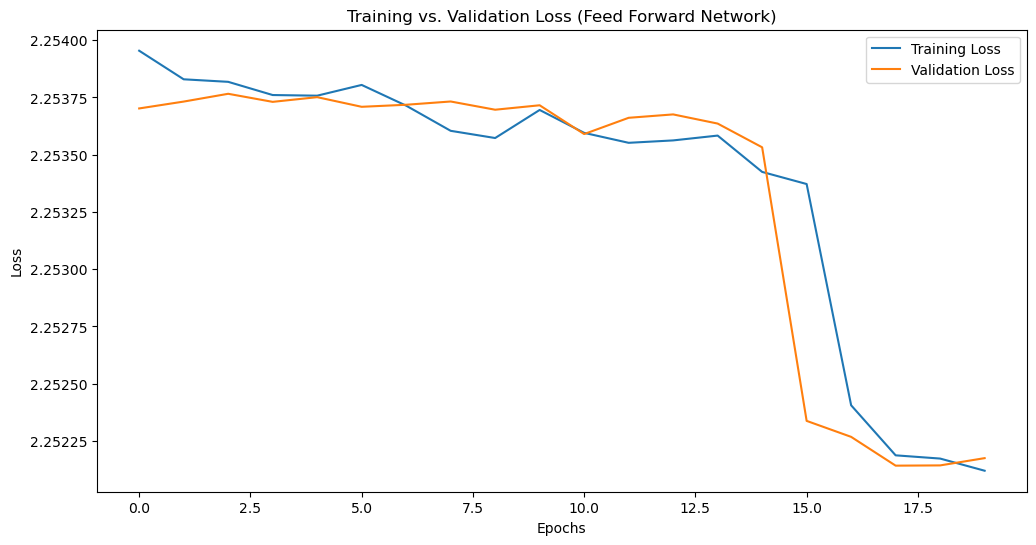

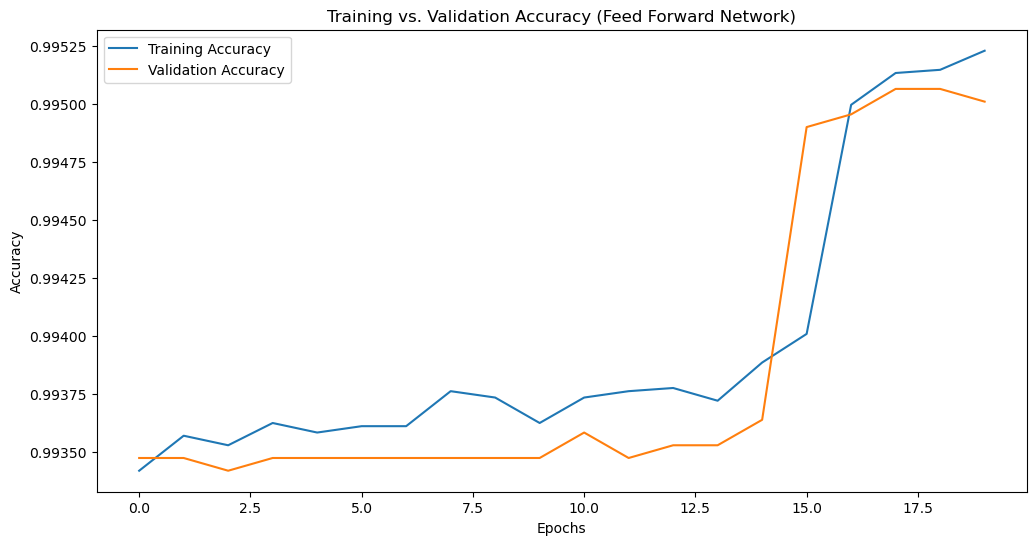

In [38]:
# Monitoring training and validation loss

# Training the Feed Forward model
train_losses, val_losses, train_accuracies, val_accuracies = train_feedforward(
    model, train_loader, test_loader, hyperparams
)


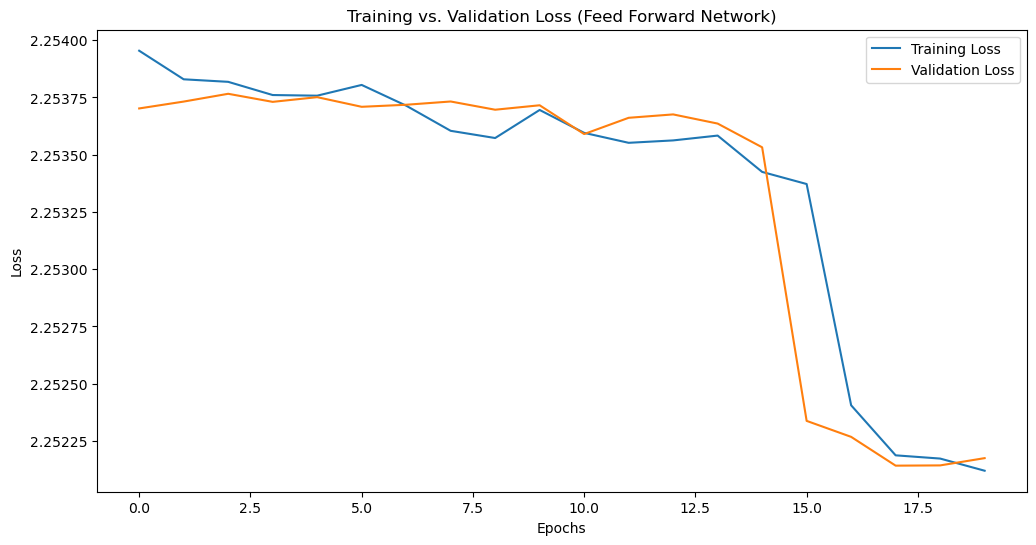

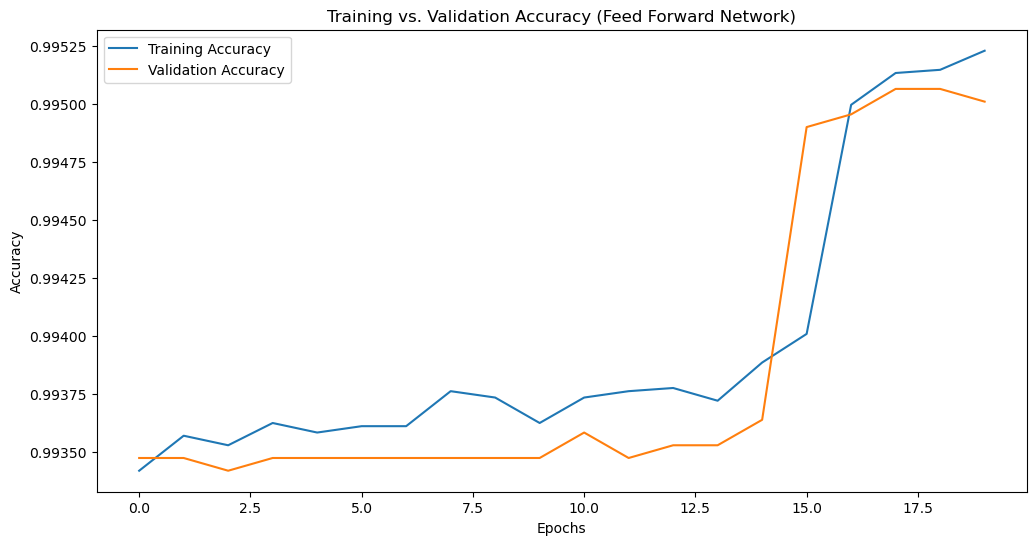

In [41]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (Feed Forward Network)")
plt.legend()
plt.savefig("feedforward_loss_plot1.png")  
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy (Feed Forward Network)")
plt.legend()
plt.savefig("feedforward_accuracy_plot1.png")  
plt.show()


** Notes and interpretation:

In [40]:
#Rechecking for data imbalance
print(dpnlp['Disease'].value_counts())

Disease
acne                               6000
pneumonia                          6000
malaria                            6000
jaundice                           6000
impetigo                           6000
psoriasis                          6000
fungal infection                   6000
typhoid                            6000
migraine                           6000
dengue                             6000
common cold                        6000
chicken pox                        6000
cervical spondylosis               6000
bronchial asthma                   6000
arthritis                          6000
urinary tract infection             170
varicose veins                      170
hypertension                        170
allergy                             170
drug reaction                       170
diabetes                            170
dimorphic hemorrhoids                50
gastroesophageal reflux disease      50
peptic ulcer disease                 50
Name: count, dtype: int64


In [ ]:
# Model Evaluation

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluating the model
evaluate_model(model, test_loader)


** Notes:

It looks like there is honestly no need to make those advanced models I had intended. While the predictions are skewed, every model i've tried so far seems to vbe predicting very well for the majority class. All I need to do from here is balance the classes and see if it would maintain that same result. If the results are consistently good after balancing the class and the model is able to predict accurately even to a healthcare professionals acceptance, I will select the model since that is teh ultimate goal. I'll be trying some Data sugmentation with NLPAug. I read that it works great fortext data augmentation by creating synonyms of the text data and augmenting the samples with new text using those synonyms

### Data Augmentation data for smaller sample diseases to balance the dataset

In [60]:
# Importing NLPAug and setting up Augmenters
import nlpaug.augmenter.word as naw

# Augmenters
synonym_augmenter = naw.SynonymAug(aug_src='wordnet')  # Augmenting using WordNet synonyms
random_swap_augmenter = naw.RandomWordAug(action="swap")  # Random word swapping
random_deletion_augmenter = naw.RandomWordAug(action="delete")  # Random word deletion


In [61]:
# Confirming package download
print(pos_tag(word_tokenize("This is a test sentence")))


[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('test', 'NN'), ('sentence', 'NN')]


#### Augmenting the Underepresented Diseases - 1

In [124]:
# Augmenting the underepresented diseases

# Filter underrepresented classes
underrepresented_classes = ['urinary tract infection', 'varicose veins', 'hypertension', 
                            'allergy', 'drug reaction', 'diabetes', 
                            'dimorphic hemorrhoids', 'gastroesophageal reflux disease', 
                            'peptic ulcer disease']

# CDataframe to hold the augmented Data
augmented_data = pd.DataFrame()

# Augmenting for each underrepresented class
for disease in underrepresented_classes:
    disease_samples = dpnlp[dpnlp['Disease'] == disease]
    augmented_samples = disease_samples.copy()

    # Augmenting the 'processed_text' column
    augmented_samples['processed_text'] = augmented_samples['processed_text'].apply(
        lambda x: synonym_augmenter.augment(x)
    )

    # Appending it to the augmented dataset
    augmented_data = pd.concat([augmented_data, augmented_samples])


The data in the underepresented classes has certainly increased but it's still nowhere near a match for the more abundant diseases. I will attempt to repeat the augmentation process, then explore a hybrid approach combining randomly undersampling the majority class and heavily oversampling the minority class. I will also explore a method called Back Translation to generate synthetic samples of the minority class. It work by translating the data into one language and then back to english to add some variation to the text.

In [121]:
print(augmented_data["Disease"].value_counts())

Disease
urinary tract infection            170
varicose veins                     170
hypertension                       170
allergy                            170
drug reaction                      170
diabetes                           170
dimorphic hemorrhoids               50
gastroesophageal reflux disease     50
peptic ulcer disease                50
Name: count, dtype: int64


In [113]:
# First few entries
print(augmented_data['processed_text'].head())

# Data types in the columns
print(augmented_data['processed_text'].apply(type).value_counts())

90580    [frequent itch urinate little output pain mict...
90581    [frequent urge urinate fiddling outturn pain i...
90582    [frequent urge urinate small output pain urina...
90583    [frequent impulse urinate little output pain m...
90584    [frequent urge urinate picayune output painful...
Name: processed_text, dtype: object
processed_text
<class 'list'>    1020
Name: count, dtype: int64


In [125]:
# Converting lists to strings to support augmentation - Cannot augment lists due to error
def flatten_and_convert_to_string(entry):
    if isinstance(entry, list):
        # Flatten the list if necessary and join it into a single string
        return ' '.join([str(item) for item in entry])
    elif isinstance(entry, str):
        return entry  # Leave strings unchanged
    else:
        return str(entry)  # Convert other data types to strings

# Applying the function to the 'processed_text' column
augmented_data['processed_text'] = augmented_data['processed_text'].apply(flatten_and_convert_to_string)

# Just checking
print(augmented_data['processed_text'].apply(type).value_counts())

processed_text
<class 'str'>    1170
Name: count, dtype: int64


In [115]:
# Checking data types again to ensure they are now strings and properly converted
print(augmented_data['processed_text'].apply(type).value_counts())
print(augmented_data['processed_text'].head())

processed_text
<class 'str'>    1020
Name: count, dtype: int64
90580    frequent itch urinate little output pain mictu...
90581    frequent urge urinate fiddling outturn pain in...
90582    frequent urge urinate small output pain urinat...
90583    frequent impulse urinate little output pain mi...
90584    frequent urge urinate picayune output painfuln...
Name: processed_text, dtype: object


#### Augmenting the last 3 Disease classes and the first 6 separately - 2

In [126]:
# Repeating augmentation for underrepresented classes

# Ensure NLPAug leverages multiprocessing
synonym_augmenter = naw.SynonymAug(aug_src='wordnet', aug_p=0.3) 

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Defining separate groups
group_170 = ['urinary tract infection', 'varicose veins', 'hypertension', 
             'allergy', 'drug reaction', 'diabetes']
group_50 = ['dimorphic hemorrhoids', 'gastroesophageal reflux disease', 'peptic ulcer disease']

# Target sizes
min_sample_size_170 = 3000
min_sample_size_50 = 6000

# Augmenting Group 1 (170 samples)
for disease in group_170:
    current_count = len(augmented_data[augmented_data['Disease'] == disease])

    while current_count < min_sample_size_170:
        new_samples = augmented_data[augmented_data['Disease'] == disease].copy()
        new_samples['processed_text'] = new_samples['processed_text'].apply(
            lambda x: synonym_augmenter.augment(x)
        )
        augmented_data = pd.concat([augmented_data, new_samples], ignore_index=True)
        current_count = len(augmented_data[augmented_data['Disease'] == disease])
        print(f"Augmented {current_count}/{min_sample_size_170} samples for {disease}.")

# Augmenting Group 2 (50 samples)
for disease in group_50:
    current_count = len(augmented_data[augmented_data['Disease'] == disease])

    while current_count < min_sample_size_50:
        new_samples = augmented_data[augmented_data['Disease'] == disease].copy()
        new_samples['processed_text'] = new_samples['processed_text'].apply(
            lambda x: synonym_augmenter.augment(x)
        )
        augmented_data = pd.concat([augmented_data, new_samples], ignore_index=True)
        current_count = len(augmented_data[augmented_data['Disease'] == disease])
        print(f"Augmented {current_count}/{min_sample_size_50} samples for {disease}.")

print("Data augmentation completed!")


Using device: cuda
Augmented 340/3000 samples for urinary tract infection.
Augmented 680/3000 samples for urinary tract infection.
Augmented 1360/3000 samples for urinary tract infection.
Augmented 2720/3000 samples for urinary tract infection.
Augmented 5440/3000 samples for urinary tract infection.
Augmented 340/3000 samples for varicose veins.
Augmented 680/3000 samples for varicose veins.
Augmented 1360/3000 samples for varicose veins.
Augmented 2720/3000 samples for varicose veins.
Augmented 5440/3000 samples for varicose veins.
Augmented 340/3000 samples for hypertension.
Augmented 680/3000 samples for hypertension.
Augmented 1360/3000 samples for hypertension.
Augmented 2720/3000 samples for hypertension.
Augmented 5440/3000 samples for hypertension.
Augmented 340/3000 samples for allergy.
Augmented 680/3000 samples for allergy.
Augmented 1360/3000 samples for allergy.
Augmented 2720/3000 samples for allergy.
Augmented 5440/3000 samples for allergy.
Augmented 340/3000 samples fo

Due to the last 3 diseases having the minmum number of samples, the while loop is playing catch up by over augmenting the larger classes to try to get the smallest classes up to the mimimum level. To resolve this, I have decided to augment each group of classes separately. The classes with 170 samples will be augmented together, and so will the samples with only 50. That way, both are augmented separately and no one is oversampled in favor of the other

In [128]:
print(augmented_data['Disease'].value_counts())

Disease
dimorphic hemorrhoids              6400
gastroesophageal reflux disease    6400
peptic ulcer disease               6400
urinary tract infection            5440
varicose veins                     5440
hypertension                       5440
allergy                            5440
drug reaction                      5440
diabetes                           5440
Name: count, dtype: int64


In [127]:
# Saving to avoid losing augmented data
augmented_data.to_csv('augmented_data_backup.csv', index=False)
print("Data augmentation completed!")


Data augmentation completed!


In [131]:
# Combining the original and augmented datasets without dropping duplicates
final_data = pd.concat([dpnlp, augmented_data], ignore_index=True)

# strings
final_data['processed_text'] = final_data['processed_text'].apply(
    lambda x: ' '.join(x) if isinstance(x, (list, np.ndarray)) else x
)

In [134]:
final_data.sample(5)

,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,...,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,processed_text,all_symptoms,processed_symptoms,embeddings
137653,peptic ulcer disease,I've lost a lot of stuff because of my bloody ...,,,,,,,,,...,,,,,,,ive lose great deal hooey bloody stool let in ...,,,"[-0.0026209126, -0.025453327, -0.063006766, -0..."
89143,typhoid,Most of the time I feel fatigued. I don't want...,chills,vomiting,fatigue,high_fever,headache,nausea,constipation,diarrhoea,...,,,,,,,time feel fatigued dont want eat anything get ...,chills vomiting fatigue high_fever headache na...,chill vomiting fatigue highfever headache naus...,"[-0.11225404, 0.08651441, -0.027166888, 0.0995..."
81351,psoriasis,"I'm having joint discomfort in my fingers, wri...",skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,,,...,,,,,,,im joint discomfort finger wrist knee pain fre...,skin_rash joint_pain skin_peeling silver_like_...,skinrash jointpain skinpeeling silverlikedusti...,"[-0.089905776, 0.35527557, -0.21597229, 0.1383..."
44810,fungal infection,"Doctor, My skin is covered in an uncomfortable...",itching,skin_rash,nodal_skin_eruptions,dischromic _patches,,,,,...,,,,,,,doctor skin covered uncomfortable rash odd pat...,itching skin_rash nodal_skin_eruptions dischro...,itching skinrash nodalskineruptions dischromic...,"[0.10903667, 0.1445864, -0.17870967, 0.3371264..."
86500,typhoid,I am experiencing extreme belly pain and const...,chills,vomiting,fatigue,high_fever,nausea,constipation,abdominal_pain,diarrhoea,...,,,,,,,experiencing extreme belly pain constipation e...,chills vomiting fatigue high_fever nausea cons...,chill vomiting fatigue highfever nausea consti...,"[0.004974524, 0.075927705, -0.21023418, 0.0956..."


In [135]:
# Saving the combined dataset to a CSV file
file_path = "final_Balanced_Augmented Datasset.csv" 
final_data.to_csv(file_path, index=False)
print(f"Combined dataset saved at {file_path}")

Combined dataset saved at final_Balanced_Augmented Datasset.csv


### NER 

Notes on Progress and bottlenecks so far

After spending days trying to download the necessary packages for NER and too much time and resources trying to complete it via alternative means, I have decided not to go forward with NER and create the models based on the vast preprocessing, taking advantage of all the pretrained embeddings and mappings from the disease oncology.

SNOMED-CT Integration - SNOMED Requires a license I don't have. Using Disease ontology (DO) SPARQL Sandbox instead

## MajorModels

### Data preparation

In [10]:
# Loading the augmented data
final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")

# Convert the disease descriptions in the 'text' column to lowercase
final_data["text"] = final_data["text"].str.lower()

# Updated dataframe
final_data.head()

C:\Users\tosin\AppData\Local\Temp\ipykernel_10276\4063227275.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")


,Disease,text,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,...,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,processed_text,all_symptoms,processed_symptoms,embeddings
0,acne,i've been having a really bad rash on my skin ...,skin_rash,pus_filled_pimples,blackheads,scurring,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ive really bad rash skin lately full pusfilled...,skin_rash pus_filled_pimples blackheads scurri...,skinrash pusfilledpimples blackhead scurring,[ 3.98078295e-03 4.02851432e-02 -7.70534985e-...
1,acne,i've been having a really bad rash on my skin ...,skin_rash,pus_filled_pimples,blackheads,scurring,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ive really bad rash skin lately full pusfilled...,skin_rash pus_filled_pimples blackheads scurri...,skinrash pusfilledpimples blackhead scurring,[ 3.98078295e-03 4.02851432e-02 -7.70534985e-...
2,acne,i've been having a really bad rash on my skin ...,pus_filled_pimples,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ive really bad rash skin lately full pusfilled...,pus_filled_pimples blackheads scurring ...,pusfilledpimples blackhead scurring,[ 3.98078295e-03 4.02851432e-02 -7.70534985e-...
3,acne,i've been having a really bad rash on my skin ...,skin_rash,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ive really bad rash skin lately full pusfilled...,skin_rash blackheads scurring,skinrash blackhead scurring,[ 3.98078295e-03 4.02851432e-02 -7.70534985e-...
4,acne,i've been having a really bad rash on my skin ...,skin_rash,pus_filled_pimples,scurring,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ive really bad rash skin lately full pusfilled...,skin_rash pus_filled_pimples scurring ...,skinrash pusfilledpimples scurring,[ 3.98078295e-03 4.02851432e-02 -7.70534985e-...


In [11]:
final_data['Disease'].value_counts()

Disease
peptic ulcer disease               6450
gastroesophageal reflux disease    6450
dimorphic hemorrhoids              6450
fungal infection                   6000
typhoid                            6000
psoriasis                          6000
pneumonia                          6000
migraine                           6000
malaria                            6000
jaundice                           6000
impetigo                           6000
acne                               6000
dengue                             6000
common cold                        6000
chicken pox                        6000
cervical spondylosis               6000
bronchial asthma                   6000
arthritis                          6000
allergy                            5610
drug reaction                      5610
diabetes                           5610
urinary tract infection            5610
varicose veins                     5610
hypertension                       5610
Name: count, dtype: int64

In [13]:
# Loading bioWordVec embeddings
# Load BioWordVec
biowordvec = KeyedVectors.load_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True)


In [14]:
# Function for creating text embeddings
def embed_text(text, embedding_model):
    words = text.split()  # Split input text into words
    word_vectors = [embedding_model[word] for word in words if word in embedding_model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  
    else:
        return np.zeros(embedding_model.vector_size)  # Fallback for missing words

# Adding embeddings
final_data['embeddings'] = final_data['text'].apply(lambda x: embed_text(x, biowordvec))

### Model 1:  Dense Neural Network with BioWordVec Embeddings

In [15]:
# Split data
X = np.stack(final_data["embeddings"])
y = pd.get_dummies(final_data["Disease"]).values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#  Model
b_model = Sequential([
    Input(shape=(X.shape[1],)),  
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(y.shape[1], activation="softmax")  
])

b_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Evaluateing the model on the test set
b_model.evaluate(X_test, y_test)

#Adding class weights to balance the importance of the minority classes
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(final_data["Disease"]), y=final_data["Disease"])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Model training
history = b_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=12,
    class_weight=class_weights_dict
)

# Evaluating the model on the test set
b_model.evaluate(X_test, y_test)


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.0612 - loss: 3.1839
Epoch 1/5
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 9s 921us/step - accuracy: 0.5092 - loss: 1.6099 - val_accuracy: 0.9638 - val_loss: 0.1364
Epoch 2/5
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 9s 920us/step - accuracy: 0.8405 - loss: 0.4836 - val_accuracy: 0.9831 - val_loss: 0.0661
Epoch 3/5
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 9s 925us/step - accuracy: 0.8846 - loss: 0.3477 - val_accuracy: 0.9925 - val_loss: 0.0349
Epoch 4/5
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 9s 925us/step - accuracy: 0.9009 - loss: 0.2951 - val_accuracy: 0.9956 - val_loss: 0.0177
Epoch 5/5
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 9s 913us/step - accuracy: 0.9149 - loss: 0.2544 - val_accuracy: 0.9975 - val_loss: 0.0141
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.9953 - loss: 0.0176


[0.01704421080648899, 0.995384931564331]

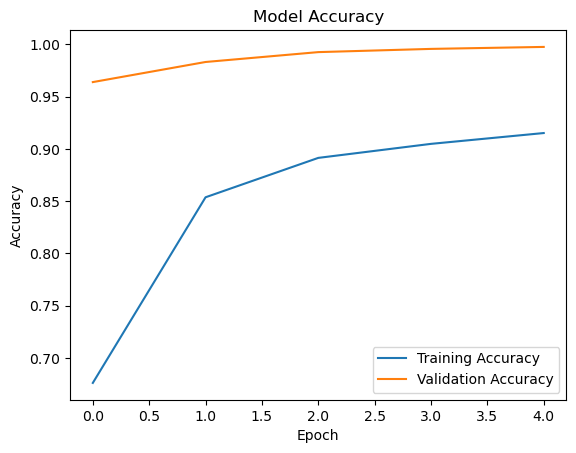

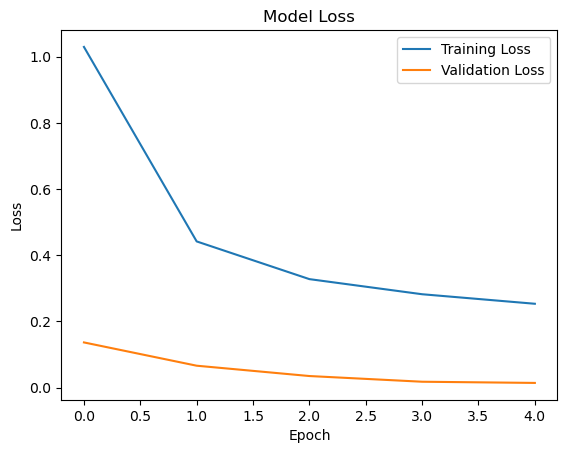

In [16]:
import matplotlib.pyplot as plt

# Training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


** Notes and interpretations

This model is performing excellently well. It consistently has high training and validation accuracy, the validation losss is lower than the training loss so no signs of overfitting. The model appears to be very well fit to the data, wuickly learning from it and making accurate predictions. On to the actual testing with the symptom descriptions I was able to collect from my classmates. Though they were only 7 and not enough to make validation data, I can still use the descriptions to try to guage the models performance. 

In [17]:
# Classification report

# Test set predictions
y_pred = b_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1) 

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# OConfusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       619
           1       0.99      0.98      0.98       583
           2       1.00      1.00      1.00       593
           3       1.00      1.00      1.00       603
           4       1.00      1.00      1.00       607
           5       1.00      1.00      1.00       590
           6       1.00      1.00      1.00       676
           7       1.00      1.00      1.00       592
           8       1.00      0.97      0.98       571
           9       1.00      1.00      1.00       658
          10       1.00      0.93      0.96       539
          11       1.00      1.00      1.00       640
          12       0.94      1.00      0.97       617
          13       1.00      1.00      1.00       543
          14       1.00      1.00      1.00       616
          15       1.00      1.00      1.00       579
          16   

In [18]:
# Making disease predictions with teh model

def predict_disease(input_text, model, embedding_model, class_names):
    # Preprocess the input text
    input_embedding = embed_text(input_text, embedding_model)
    input_embedding = np.expand_dims(input_embedding, axis=0)   

    # Predicting probabilities
    predictions = model.predict(input_embedding)

    # Top 5 predictions
    top_indices = predictions[0].argsort()[-5:][::-1]  
    top_diseases = [(class_names[idx], predictions[0][idx]) for idx in top_indices]

    return top_diseases

# Class names
class_names = pd.get_dummies(final_data["Disease"]).columns.tolist()

In [19]:
#Testing function with sample input
input_text = "The past few days I haven’t been feeling well. My head has a full feeling. And my sinuses are all congested. I can’t go 10 minutes without coughing or sneezing. "
top_diseases = predict_disease(input_text, b_model, biowordvec, class_names)

# Predictions
print("Top predicted diseases with probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Top predicted diseases with probabilities:
common cold: 0.80
allergy: 0.20
bronchial asthma: 0.00
drug reaction: 0.00
pneumonia: 0.00


In [23]:
# Sample input test 5
input_text = "I have been having strange rashes all oer my body with some having round blusters. They are not itchy, just red and around my abdomen. I am always tired and I cant sleep well"
top_diseases = predict_disease(input_text, b_model, biowordvec, class_names)

#   Print the predictions
print("Top predicted diseases with probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top predicted diseases with probabilities:
fungal infection: 0.73
drug reaction: 0.18
bronchial asthma: 0.03
acne: 0.02
migraine: 0.02


In [20]:
#Sample input test 2 - This result is a little iffy. How did we get hyperytension from that?
input_text = "I am getting a severe headache and i am unable to sleep "
top_diseases = predict_disease(input_text, b_model, biowordvec, class_names)

#   Print the predictions
print("Top predicted diseases with probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Top predicted diseases with probabilities:
hypertension: 0.99
typhoid: 0.00
bronchial asthma: 0.00
migraine: 0.00
drug reaction: 0.00


In [21]:
# Sample input test 3
input_text = "I had few blood clot patches on my legs. It happens with me when I'm feeling weak or I had few foot cramps during winter."
top_diseases = predict_disease(input_text, b_model, biowordvec, class_names)

#   Print the predictions
print("Top predicted diseases with probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top predicted diseases with probabilities:
varicose veins: 0.99
fungal infection: 0.00
dengue: 0.00
psoriasis: 0.00
chicken pox: 0.00


In [22]:
# Sample input test 4
input_text = "ts just a normal cough and fever"
top_diseases = predict_disease(input_text, b_model, biowordvec, class_names)

#   Print the predictions
print("Top predicted diseases with probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Top predicted diseases with probabilities:
bronchial asthma: 1.00
allergy: 0.00
drug reaction: 0.00
common cold: 0.00
diabetes: 0.00


 Based on the outputs of all the test samples, it looks to me like descriptions that are more verbose or fuller tend to have better predictions that closely match the predictions of Medical chatGPT. While all the predictions seem possible, some are more likely than others. Shorter descriptions look like they have far fetched predictions. For instance, even though I know hypertension can be a likely disease for sample input 2, it's too little information to predict hypertension. Overall, the model performs much better with more information provided.

### Model 2: Hybrid model with CNN and LSTM - Did not quite work out due to provlems with the input dimensions and getting the data in the right format for the CNN

In [81]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from gensim.models import KeyedVectors

In [91]:
# Load BioWordVec embeddings
biowordvec = KeyedVectors.load_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True)


In [ ]:
#   Embed text using BioWordVec
def embed_text(text, embedding_model):
    words = text.split()
    word_vectors = [embedding_model[word] for word in words if word in embedding_model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)



In [106]:
#   Preprocess data into embeddings with padding/truncation
def preprocess_data(data, embedding_model, max_length, embedding_dim):
    processed_embeddings = []
    for text in data["text"]:
        # Generate embeddings
        embedded_text = embed_text(text, embedding_model)

        # Handle empty inputs with zero vectors
        if embedded_text.shape[0] == 0:
            embedded_text = np.zeros((1, embedding_dim))

        # Truncate or pad embeddings to max_length
        if len(embedded_text) > max_length:
            processed_embeddings.append(embedded_text[:max_length])
        else:
            padding = np.zeros((max_length - len(embedded_text), embedding_dim))
            processed_embeddings.append(np.pad(embedded_text, ((0, max_length - len(embedded_text)), (0, 0)), mode='constant'))


    return np.array(processed_embeddings)  # Final shape: (num_samples, max_length, embedding_dim)




In [107]:
X = preprocess_data(deduplicated_data, biowordvec, max_length, embedding_dim)
print("Processed Embedding Shape:", X.shape)  # Should be (num_samples, max_length, embedding_dim)


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (1,2)

In [104]:
#   Load and preprocess the data
final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")
embedding_dim = biowordvec.vector_size
max_length = 200  # Define a consistent max sequence length

# Drop duplicates based on the 'text' column
deduplicated_data = final_data.drop_duplicates(subset=["text"])
print("Unique text entries after deduplication:", deduplicated_data["text"].nunique())

# Re-preprocess the deduplicated data
X = preprocess_data(deduplicated_data, biowordvec, max_length, embedding_dim)
y = pd.get_dummies(deduplicated_data["Disease"]).values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


Unique text entries after deduplication: 1153
X_train shape: (807, 1, 200)
X_val shape: (173, 1, 200)
X_test shape: (173, 1, 200)


C:\Users\tosin\AppData\Local\Temp\ipykernel_16868\1450999169.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")


In [105]:
#   Define the CNN-LSTM hybrid model
num_classes = y_train.shape[1]
max_length = 200  # Same as the max_length used in preprocess_data

cnn_lstm_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_length, embedding_dim)),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dense(num_classes, activation='softmax')
])


print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


C:\Users\tosin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


X_train shape: (807, 1, 200)
X_val shape: (173, 1, 200)
X_test shape: (173, 1, 200)


In [ ]:
# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define class weights (if needed, based on label distribution)
class_weights = {i: max(np.bincount(np.argmax(y_train, axis=1))) / count
                 for i, count in enumerate(np.bincount(np.argmax(y_train, axis=1)))}

# Train the model
history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights
)

# Evaluate on the test set
test_loss, test_accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

#   Generate metrics and plots
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Generate predictions and classification report
y_pred = np.argmax(cnn_lstm_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=pd.get_dummies(final_data['Disease']).columns))

# Plot training and validation metrics
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

#   Inference for symptom descriptions
def predict_disease(input_text, model, embedding_model, class_names):
    input_embedding = embed_text(input_text, embedding_model)
    input_embedding = np.expand_dims(input_embedding, axis=0)  # Add batch dimension
    predictions = model.predict(input_embedding)[0]  # Predict probabilities
    top_indices = predictions.argsort()[-5:][::-1]  # Get top 5 predictions
    top_diseases = [(class_names[idx], predictions[idx]) for idx in top_indices]
    return top_diseases

# Class names for predictions
class_names = pd.get_dummies(final_data["Disease"]).columns.tolist()

# Example usage
input_text = "I have a fever and sore throat with a mild headache."
top_diseases = predict_disease(input_text, cnn_lstm_model, biowordvec, class_names)
print("Top Predicted Diseases with Probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")

In [78]:
from sklearn.model_selection import train_test_split

# Ensure consistent shape for embeddings
final_data["embeddings"] = final_data["embeddings"].apply(
    lambda x: np.pad(
        np.array(x), 
        ((0, max_length - len(x)), (0, 0)), 
        mode="constant"
    ) if len(x) < max_length else np.array(x)[:max_length]
)

# Stack the embeddings into a numpy array
X = np.stack(final_data["embeddings"].values)
y = pd.get_dummies(final_data["Disease"]).values  # One-hot encoding for labels

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# Reshape is unnecessary because embeddings should already be in the correct shape
# Confirming shapes
assert X_train.shape[1:] == (200, biowordvec.vector_size), "Embedding shape mismatch"


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [79]:
# Check for invalid entries in the embeddings column
invalid_rows = final_data[final_data["embeddings"].apply(lambda x: not isinstance(x, (np.ndarray, list)) or len(x) == 0)]
print("Invalid Rows in Embeddings Column:")
print(invalid_rows)


Invalid Rows in Embeddings Column:
                     Disease  \
0                       acne   
1                       acne   
2                       acne   
3                       acne   
4                       acne   
...                      ...   
143005  peptic ulcer disease   
143006  peptic ulcer disease   
143007  peptic ulcer disease   
143008  peptic ulcer disease   
143009  peptic ulcer disease   

                                                     text           Symptom_1  \
0       I've been having a really bad rash on my skin ...           skin_rash   
1       I've been having a really bad rash on my skin ...           skin_rash   
2       I've been having a really bad rash on my skin ...  pus_filled_pimples   
3       I've been having a really bad rash on my skin ...           skin_rash   
4       I've been having a really bad rash on my skin ...           skin_rash   
...                                                   ...                 ...   
143005  I've 

In [76]:
# Ensure X_train has the correct shape for input to Conv1D
X_train = np.stack(final_data["embeddings"].apply(lambda x: np.array(x)).values)
X_val = np.stack(val_data["embeddings"].apply(lambda x: np.array(x)).values)
X_test = np.stack(test_data["embeddings"].apply(lambda x: np.array(x)).values)

# Reshape data to include the embedding dimension
X_train = X_train.reshape(-1, max_length, embedding_dim)
X_val = X_val.reshape(-1, max_length, embedding_dim)
X_test = X_test.reshape(-1, max_length, embedding_dim)

# Define the CNN-LSTM hybrid model
cnn_lstm_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_length, embedding_dim)),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define class weights (optional, based on label distribution)
class_weights = {i: max(np.bincount(np.argmax(y_train, axis=1))) / count
                 for i, count in enumerate(np.bincount(np.argmax(y_train, axis=1)))}

# Train the model
history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights
)


NameError: name 'val_data' is not defined

In [ ]:
# Train the hybrid model
history_hybrid = hybrid_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,  # If using class weights
    verbose=1,
)

In [ ]:
# Evaluate the hybrid model
test_loss, test_accuracy = hybrid_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history_hybrid.history['accuracy'], label='Training Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_hybrid.history['loss'], label='Training Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Hybrid Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = hybrid_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=class_names)
print(report)

import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:

# Making predictions from sample symptom descriptions
def predict_disease(input_text, model, embedding_model, class_names):
    # Preprocess the input text
    input_embedding = embed_text(input_text, embedding_model)
    input_embedding = np.expand_dims(input_embedding, axis=0)  # Add batch dimension

    # Predict probabilities
    predictions = model.predict(input_embedding)[0]

    # Get top 5 predictions
    top_indices = predictions.argsort()[-5:][::-1]
    top_diseases = [(class_names[idx], predictions[idx]) for idx in top_indices]

    return top_diseases

# Test the function
input_text = "I have a fever, sore throat, and a mild headache."
top_diseases = predict_disease(input_text, hybrid_model, biowordvec, class_names)

print("Top predicted diseases with probabilities:")
for disease, prob in top_diseases:
    print(f"{disease}: {prob:.2f}")


### Model 3: Experimental Zero-Shot learning with Disease ontology 

In [ ]:
# Installing SPARQLWrapper to access the disease ontology
#!pip install SPARQLWrapper

In [130]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Removing special characters
    return text.strip()

# Function to compute sentence embeddings
def sentence_embedding(sentence, word2index, embedding_matrix):
    words = sentence.split()
    indices = [word2index[word] for word in words if word in word2index]
    if indices:
        
        # moving embeddings for this sentence to GPU
        embeddings = embedding_matrix[indices].to("cuda")
        return embeddings.mean(dim=0)  
    else:
        return torch.zeros(embedding_matrix.shape[1], device="cuda") 

In [123]:
from SPARQLWrapper import SPARQLWrapper, JSON

#  initializing SPARQL endpoint
sparql = SPARQLWrapper("https://sparql.disease-ontology.org/")
sparql.setQuery("""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?id ?label ?source
WHERE {
  ?iri a owl:Class ;
       oboInOwl:id ?id ;
       rdfs:label ?label ;
       obo:IAO_0000115 ?definition ;
       oboInOwl:hasOBONamespace "disease_ontology" .

  # Ignore obsolete
  FILTER NOT EXISTS { ?iri owl:deprecated ?deprecated . }

  [] owl:annotatedSource ?iri ;
     owl:annotatedProperty obo:IAO_0000115 ;
     owl:annotatedTarget ?definition ;
     oboInOwl:hasDbXref ?def_src .

  BIND(REPLACE(?def_src, "url:", "") AS ?source)
}
""")
sparql.setReturnFormat(JSON)

# Results
results = sparql.query().convert()

# DataFrame - Saves my time
data = []
for result in results["results"]["bindings"]:
    data.append({
        "Disease ID": result["id"]["value"],
        "Disease Name": result["label"]["value"],
        "Source": result["source"]["value"]
    })

disease_descriptions = pd.DataFrame(data)

In [136]:
#!pip install accelerate transformers[torch]


In [131]:
# Loading BioWordVec and preparing embeddings
#biowordvec already in enviromnet - I.e the word vectors
embedding_matrix = torch.tensor(biowordvec.vectors, device="cpu")
word2index = {word: idx for idx, word in enumerate(biowordvec.index_to_key)}

# Adding embeddings to disease ontology
disease_descriptions['embedding'] = disease_descriptions['Disease Name'].apply(
    lambda x: sentence_embedding(x, word2index, embedding_matrix)
)

# Dataset
final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")

#filtering non_string values
final_data['processed_symptoms'] = final_data['processed_symptoms'].apply(
    lambda x: str(x) if not isinstance(x, str) else x
)

# handling missing values
final_data['processed_symptoms'] = final_data['processed_symptoms'].fillna("")

symptom_descriptions = final_data['processed_symptoms'].unique()
symptom_descriptions = symptom_descriptions.dropna() #filtering out Nan Values

symptom_embeddings = torch.stack(
    [sentence_embedding(preprocess_text(symptom), word2index, embedding_matrix)
     for symptom in symptom_descriptions]
)

# Generating embeddings for symptoms
symptom_embeddings = torch.stack(
    [sentence_embedding(symptom, word2index, embedding_matrix) for symptom in symptom_descriptions]
)

#  Cosine similarities
disease_embedding_matrix = torch.stack(disease_descriptions['embedding'].tolist())
similarities = torch.nn.functional.cosine_similarity(
    symptom_embeddings.unsqueeze(1),  # Reshape for broadcasting
    disease_embedding_matrix.unsqueeze(0),
    dim=-1,
)

# Smptoms to disease matching
top_k = 5  
for i, symptom in enumerate(symptom_descriptions):
    top_indices = torch.topk(similarities[i], top_k).indices
    top_diseases = disease_descriptions.iloc[top_indices.tolist()]['Disease Name']
    print(f"Symptom: '{symptom}' -> Top Diseases: {list(top_diseases)}")
    

C:\Users\tosin\AppData\Local\Temp\ipykernel_16868\3061724769.py:12: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")


Symptom: 'skinrash pusfilledpimples blackhead scurring' -> Top Diseases: ['contagious pustular dermatitis', 'contagious pustular dermatitis', 'seborrheic dermatitis', 'seborrheic infantile dermatitis', 'seborrheic infantile dermatitis']
Symptom: 'pusfilledpimples blackhead scurring' -> Top Diseases: ['hypodermyiasis', 'hypodermyiasis', 'hypodermyiasis', 'coccidiosis', 'lice infestation']
Symptom: 'skinrash blackhead scurring' -> Top Diseases: ['contagious pustular dermatitis', 'contagious pustular dermatitis', 'seborrheic dermatitis', 'seborrheic infantile dermatitis', 'seborrheic infantile dermatitis']
Symptom: 'skinrash pusfilledpimples scurring' -> Top Diseases: ['skin melanoma', 'skin melanoma', 'skin melanoma', 'skin tag', 'skin angiosarcoma']
Symptom: 'skinrash pusfilledpimples blackhead' -> Top Diseases: ['contagious pustular dermatitis', 'contagious pustular dermatitis', 'seborrheic dermatitis', 'seborrheic infantile dermatitis', 'seborrheic infantile dermatitis']
Symptom: 'con

## Leveraging Disease Oncology to create a clinicalBERT disease prediction model
SNOMED-CT Integration - SNOMED Requires a license I don't have. Using Disease ontology (DO) SPARQL Sandbox instead

This is useful for incorporating zero-Shot learning so the model isn't only limited to the symptoms and diseases currently available in my dataset but can predict other diseases as well. 

-Didn't end up working out but only because my system could not carry it and I couldn't get the install of the package it was requested. I installed, uninstalled and reinstalled it severally to no avail. However, I was able to complete the disesase to symptom mappings and it was actually accounting for diseases and symptoms not present in my training data which is incredible. The disease oncology would definitely help if this model were to be advanced in the future so i'm leaving it in.

---Note to self. Give a brief decription of this thing and what it does in the paper

In [141]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import torch



In [132]:
# Preprocessing

import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset

# Load your dataset
final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")

# Handle missing or non-string values
final_data['processed_symptoms'] = final_data['processed_symptoms'].apply(
    lambda x: str(x) if not isinstance(x, str) else x
).fillna("")

# Extract unique symptoms and their corresponding diseases
symptom_descriptions = final_data['processed_symptoms']
disease_labels = final_data['Disease']

# Tokenizer for Clinical BERT
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Encode symptom descriptions
symptom_encodings = tokenizer(
    list(symptom_descriptions), padding=True, truncation=True, return_tensors="pt"
)

# Create a mapping for diseases
unique_diseases = disease_labels.unique()
disease_to_index = {disease: idx for idx, disease in enumerate(unique_diseases)}
index_to_disease = {idx: disease for disease, idx in disease_to_index.items()}

# Map diseases to indices
disease_indices = disease_labels.map(disease_to_index).values


C:\Users\tosin\AppData\Local\Temp\ipykernel_16868\3855871087.py:10: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv("final_Balanced_Augmented Datasset.csv")


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

C:\Users\tosin\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tosin\.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [133]:
# creating a custom dataset to organise symptoms and their labels for pytorch

class SymptomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


# Split data into training and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    symptom_descriptions, disease_indices, test_size=0.2, random_state=42
)

train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, return_tensors="pt")

train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)


In [134]:
# Finetuning a clinicalBERT model for disease prediction

from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Loading Clinical BERT with a classification head
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT", 
    num_labels=len(unique_diseases)
)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [149]:
# Defining training arguments
training_args = TrainingArguments(
    output_dir="./results", 
    eval_strategy="epoch",  
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir='./logs',
)

# The Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Training the model
trainer.train()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

# Thank you Professor

Thank you for sharing your knowledge on NLP Professor. It has been a pleasure learning from you and embracing the challenges that came with this class. I wish you the best and look forward to reaching out to you in the future potentially for the advancement of this project